In [1]:
#https://networkx.github.io/documentation/networkx-1.9/_modules/networkx/generators/random_graphs.html

In [2]:
import itertools
import random
import math
import networkx as nx
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx.generators.classic import empty_graph, path_graph, complete_graph

from collections import defaultdict

__all__ = ['fast_gnp_random_graph']

%matplotlib inline

In [3]:
def fast_gnp_random_graph(n, p, seed=None, directed=False):
    """Return a multi directed graph G_{n,p} (Erdős-Rényi graph, binomial graph).

    Parameters
    ----------
    n : int
        The number of nodes.
    p : float
        Probability for edge creation.
    seed : int, optional
        Seed for random number generator (default=None).
    directed : bool, optional (default=False)
        If True return a directed graph

    Notes
    -----
    The G_{n,p} graph algorithm chooses each of the [n(n-1)]/2
    (undirected) or n(n-1) (directed) possible edges with probability p.

    This algorithm is O(n+m) where m is the expected number of
    edges m=p*n*(n-1)/2.

    It should be faster than gnp_random_graph when p is small and
    the expected number of edges is small (sparse graph).

    See Also
    --------
    gnp_random_graph

    References
    ----------
    .. [1] Vladimir Batagelj and Ulrik Brandes,
       "Efficient generation of large random networks",
       Phys. Rev. E, 71, 036113, 2005.
    """
    G = empty_graph(n)
    G.name="fast_gnp_random_graph(%s,%s)"%(n,p)

    if not seed is None:
        random.seed(seed)

    if p <= 0 or p >= 1:
        return nx.gnp_random_graph(n,p,directed=directed)

    w = -1
    lp = math.log(1.0 - p)

    if directed:
        G = nx.MultiDiGraph(G)
        # Nodes in graph are from 0,n-1 (start with v as the first node index).
        v = 0
        while v < n:
            lr = math.log(1.0 - random.random())
            w = w + 1 + int(lr/lp)
            if v == w: # avoid self loops
                w = w + 1
            while  w >= n and v < n:
                w = w - n
                v = v + 1
                if v == w: # avoid self loops
                    w = w + 1
            if v < n:
                G.add_edge(v, w)
    else:
        # Nodes in graph are from 0,n-1 (start with v as the second node index).
        v = 1
        while v < n:
            lr = math.log(1.0 - random.random())
            w = w + 1 + int(lr/lp)
            while w >= v and v < n:
                w = w - v
                v = v + 1
            if v < n:
                G.add_edge(v, w)
    return G

# Define population with subset of nodes with trait A attribute

In [4]:
#create undirected network with 1000 nodes, 0.5% probability edge creation
G = fast_gnp_random_graph(1000, 0.005, 1, directed = False)

In [5]:
#check how connected the nodes are, on average
connections = []
for i in range(1000):
    connections.append(G.degree[i])
statistics.mean(connections)

4.968

In [6]:
#create list of dictionaries with value_A key/values (30% with trait_A)
trait_A = []
for i in range(int(0.3*len(G))):
    trait_A.append({'trait_A':1})
for i in range(int(0.7*len(G))):
    trait_A.append({'trait_A':0})

random.shuffle(trait_A)

#dict of dicts for iterating
A_dict = {}
for i in trait_A:
    for key,value in enumerate(trait_A):
        A_dict[key] = value
        
#create list of dictionaries with value_A key/values (80% with trait_B)
trait_B = []
for i in range(int(0.8*len(G))):
    trait_B.append({'trait_B':1})
for i in range(int(0.2*len(G))):
    trait_B.append({'trait_B':0})

random.shuffle(trait_B)

#dict of dicts for iterating
B_dict = {}
for i in trait_B:
    for key,value in enumerate(trait_B):
        B_dict[key] = value
        
#create list of dictionaries with value_A key/values (60% with trait_C)
trait_C = []
for i in range(int(0.6*len(G))):
    trait_C.append({'trait_C':1})
for i in range(int(0.4*len(G))):
    trait_C.append({'trait_C':0})

random.shuffle(trait_C)

#dict of dicts for iterating
C_dict = {}
for i in trait_C:
    for key,value in enumerate(trait_C):
        C_dict[key] = value
        
#assign attributes to each node in network G
nx.set_node_attributes(G, A_dict)
nx.set_node_attributes(G, B_dict)
nx.set_node_attributes(G, C_dict)

C:\Users\Adam\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


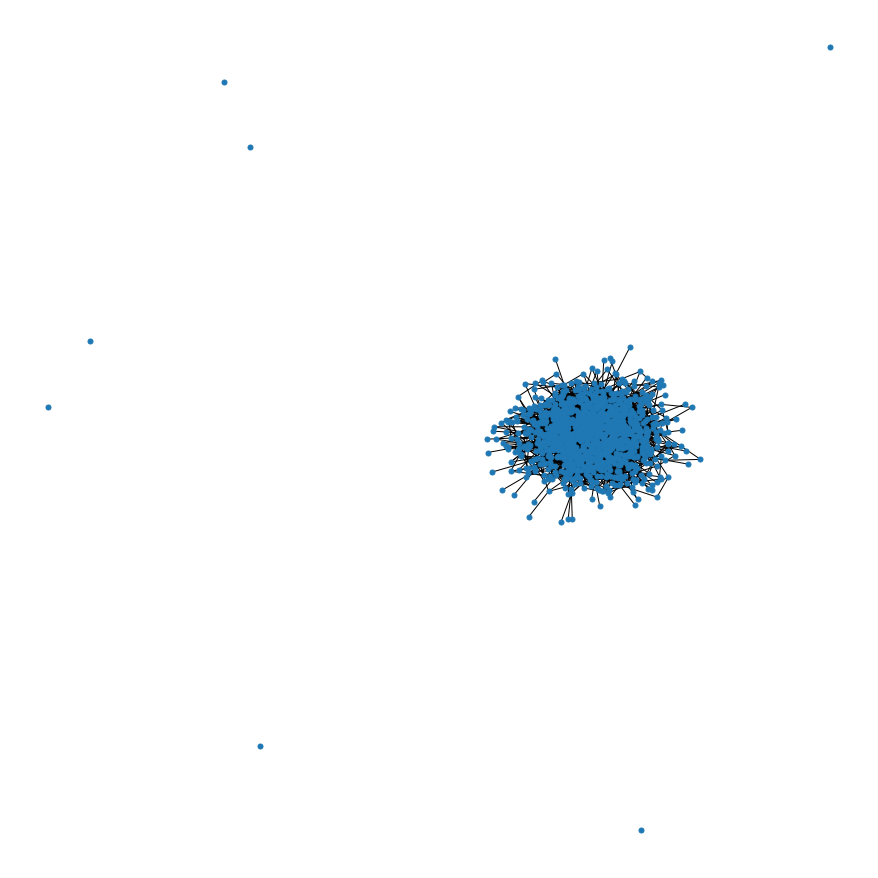

In [7]:
#visualize network
plt.figure(3,figsize=(12,12)) 
nx.draw_spring(G,node_size=25)

# Create seed sample from population that is not representative w.r.t Traits

In [8]:
#Subgraph from G of only nodes with trait A and without trait A
nodes_with_A = [key for key, value in nx.get_node_attributes(G, 'trait_A').items() if value == 1]
nodes_no_A = [key for key, value in nx.get_node_attributes(G, 'trait_A').items() if value == 0]
G_with_A = G.subgraph(nodes_with_A)
G_no_A = G.subgraph(nodes_no_A)

In [9]:
#function that creates a subgraph object as a sample from G with trait A of sample size 'size'
def nx_sample_with_A(graph, size):
    '''Return subgraph sample from G_with_A.
       graph = nx graph of population
       size = int size of sample'''
    sampled_nodes = random.sample(G_with_A.nodes, size)
    sampled_graph = G.subgraph(sampled_nodes)
    return sampled_graph

#function that creates a subgraph object as a sample from G without trait A of sample size 'size'
def nx_sample_no_A(graph, size):
    '''Return subgraph sample from G_no_A.
       graph = nx graph of population
       size = int size of sample'''
    sampled_nodes = random.sample(G_no_A.nodes, size)
    sampled_graph = G.subgraph(sampled_nodes)
    return sampled_graph

In [10]:
#draw sample of size 95 from G_with_A and size 5 from G_no_A (5% with A versus 30% in the population)
sample_with_A = nx_sample_with_A(G, 95)
sample_no_A = nx_sample_no_A(G, 5)
seed_sample = nx.compose(sample_with_A, sample_no_A)

# Collect information about each node in sample:
## 1. Total number of contacts for each node

In [11]:
#function that collects the degree for each node in the network (number of contacts)
def num_contacts(graph):
    '''Return dictionary of node id and corresponding degree'''
    contacts = [val for (node, val) in graph.degree]
    merge_dict = dict(zip(list(graph.nodes), contacts))
    return merge_dict

In [12]:
#for each node in the sample, create a dict with node id and node degree in the primary network
sample_contacts = {key:value for key, value in num_contacts(G).items() if key in list(seed_sample.nodes())}

Text(0, 0.5, 'Count')

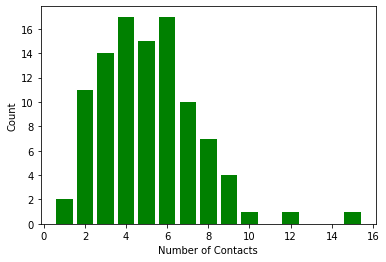

In [13]:
#graph the distribution of contacts for each node in the sample
import collections
counter=collections.Counter(list(sample_contacts.values()))
plt.bar(counter.keys(), counter.values(), color='g')
plt.xlabel('Number of Contacts')
plt.ylabel('Count')

## 2. For each node in the sample, a list of contacts in G

In [14]:
#function that determines if given node has trait_A attribute == 1
def has_A(graph, node):
    '''Return True if node has trait_A'''
    if nx.get_node_attributes(graph, 'trait_A')[node] == 1:
        return True
    else:
        return False

In [15]:
#dict of each node in seed_sample and that node's list of contacts in G
contacts_list_of_list = []
for i in list(seed_sample.nodes()):
    contacts_list_of_list.append((list(G.neighbors(i))))
contacts_dict = dict(zip(list(seed_sample.nodes()), contacts_list_of_list))

#show top 10 results. node, list of contacts
#[print(v) for i, v in enumerate(contacts_dict.items()) if i < 10]

## 3. List of each node's total contacts

In [16]:
#list of seed_sample's unique contacts with trait_A
contacts_list = [[ele for ele in sub if has_A(G,ele) == True] for sub in contacts_list_of_list]
contacts_list = set(x for l in contacts_list for x in l)
contacts_list = list(contacts_list)

# Chain Sampling

## 1. Choose a random sample from the seed sample
    a) And for the new sample, record the percentage with traits A B and C

In [17]:
def chain_sample(seed, waves, sample = 0, checker = 1, results = None):
    ''' seed is the starting sample
        waves is an int for the number of waves for iterating
        This function runs chain sampling and updates table with results for each wave'''
    
    if checker > waves:
        return
    elif sample == 0:
        #initialize results table from seed sample
        sampling_results = [[0,
                             list(nx.get_node_attributes(seed_sample, 'trait_A').values()).count(1)/
                             len(list(nx.get_node_attributes(seed_sample, 'trait_A').values())),
                             list(nx.get_node_attributes(seed_sample, 'trait_B').values()).count(1)/
                             len(list(nx.get_node_attributes(seed_sample, 'trait_B').values())),
                             list(nx.get_node_attributes(seed_sample, 'trait_C').values()).count(1)/
                             len(list(nx.get_node_attributes(seed_sample, 'trait_C').values()))]]
        
        results = pd.DataFrame(sampling_results, columns=['sampling_wave', 'trait_A', 'trait_B', 'trait_C'])
        
        current_sample = G.subgraph(random.sample(list(seed.nodes()), k=random.choice(range(40,60))))
        
        #update results table
        results.loc[len(results)] = [checker,
                                     list(nx.get_node_attributes(current_sample, 'trait_A').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_A').values())),
                                     list(nx.get_node_attributes(current_sample, 'trait_B').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_B').values())),
                                     list(nx.get_node_attributes(current_sample, 'trait_C').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_C').values()))]
        
        #recursively run sample
        chain_sample(seed, waves, current_sample, sum([1, checker]), results)
        return results
    else:
        #dictionary with key/value as node/list of contacts in G
        contacts_list_of_list = []
        for i in list(sample.nodes()):
            contacts_list_of_list.append((list(G.neighbors(i))))
        contacts_dict = dict(zip(list(sample.nodes()), contacts_list_of_list))

        #for each node in new sample, refer contacts based on contacts degree and then compile a total list
        output = []
        for i in list(contacts_dict.keys()):
            if contacts_dict[i] != []:
                output.append(random.sample(contacts_dict[i], k=random.choice(range(len(contacts_dict[i])))))
        output = sorted(list(x for l in output for x in l))
        current_sample = nx.subgraph(G, output)
        
        #update results table
        results.loc[len(results)] = [checker, 
                                     list(nx.get_node_attributes(current_sample, 'trait_A').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_A').values())),
                                     list(nx.get_node_attributes(current_sample, 'trait_B').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_B').values())),
                                     list(nx.get_node_attributes(current_sample, 'trait_C').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait_C').values()))]
        
        #recursively run sample
        chain_sample(seed, waves, current_sample, sum([1, checker]), results)

In [18]:
df = chain_sample(seed_sample, 10)

In [19]:
#get seed_sample proportions for traits A B and C
a_proportion = list(nx.get_node_attributes(seed_sample, 'trait_A').values()).count(1)/len(list(nx.get_node_attributes(seed_sample, 'trait_A').values()))
b_proportion = list(nx.get_node_attributes(seed_sample, 'trait_B').values()).count(1)/len(list(nx.get_node_attributes(seed_sample, 'trait_B').values()))
c_proportion = list(nx.get_node_attributes(seed_sample, 'trait_C').values()).count(1)/len(list(nx.get_node_attributes(seed_sample, 'trait_C').values()))
print([0.30, 0.80, 0.60])
print([a_proportion, b_proportion, c_proportion])

[0.3, 0.8, 0.6]
[0.95, 0.83, 0.62]


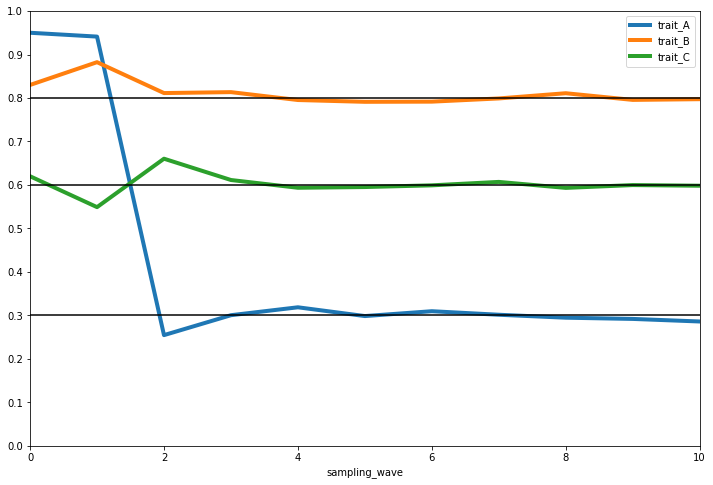

In [20]:
fig = df.plot(x='sampling_wave', figsize=(12,8), yticks=np.arange(0,1.1,0.1), lw=4)
fig = plt.axhline(y=0.3, color='black', linestyle='-')
fig = plt.axhline(y=0.8, color='black', linestyle='-')
fig = plt.axhline(y=0.6, color='black', linestyle='-')

In [22]:
A = nx.to_numpy_matrix(G)

In [23]:
A

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])